# SVGD without kernels

In [6]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload

### Main

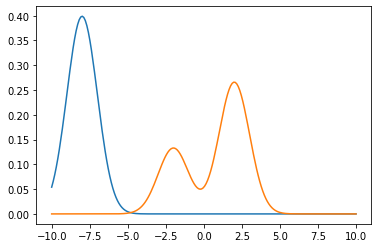

In [12]:
# setup = distributions.funnel
# target, proposal = setup.get()

target = distributions.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])
proposal = distributions.Gaussian(-8, 1)
setup = distributions.Setup(target, proposal)

setup.plot(lims=(-10, 10))

rescale $\phi^*$ by
$$
\alpha = \frac{\text{SD}(\phi^*)}{2 \lambda \Vert \phi^* \Vert_{L^2(q)}^2}
$$
This is like training the loss $L(\alpha) = -\text{SD}(\alpha \phi^*) + \lambda \Vert \alpha \phi^* \Vert^2_{L_2(q)}$ to convergence: the minum is given by $\alpha$ as above.

In [13]:
def phistar_batched(params, _, particles, aux=False):
    kernel = kernels.get_rbf_kernel(1)
    inducing_particles = params
    phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
    l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
    ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
    alpha = ksd / (2*lambda_reg*l2_phi_squared)
    if aux:
        return -alpha*vmap(phi)(particles), {"ksd": ksd, "alpha": alpha}
    else:
        return -alpha*vmap(phi)(particles)


def phistar_batched_adaptive(params, _, particles, aux=False):
    inducing_particles = params
    bandwidth = kernels.median_heuristic(inducing_particles)
    kernel = kernels.get_rbf_kernel(bandwidth)
    phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
    l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
    ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
    alpha = ksd / (2*lambda_reg*l2_phi_squared)
    if aux:
        return -alpha*vmap(phi)(particles), {"ksd": ksd, "alpha": alpha}
    else:
        return -alpha*vmap(phi)(particles)

In [14]:
n_steps = 500

In [15]:
key, subkey = random.split(key)
neural_svgd_learner, neural_svgd_particles, err = flows.neural_svgd_flow(subkey, setup, n_steps=n_steps, sizes=[32, 32, 1])

# key, subkey = random.split(key)
kernel_gradient, svgd_particles = flows.svgd_flow(subkey, setup, scaled=True, n_steps=n_steps)

100%|██████████| 500/500 [00:09<00:00, 52.26it/s]


## Plot

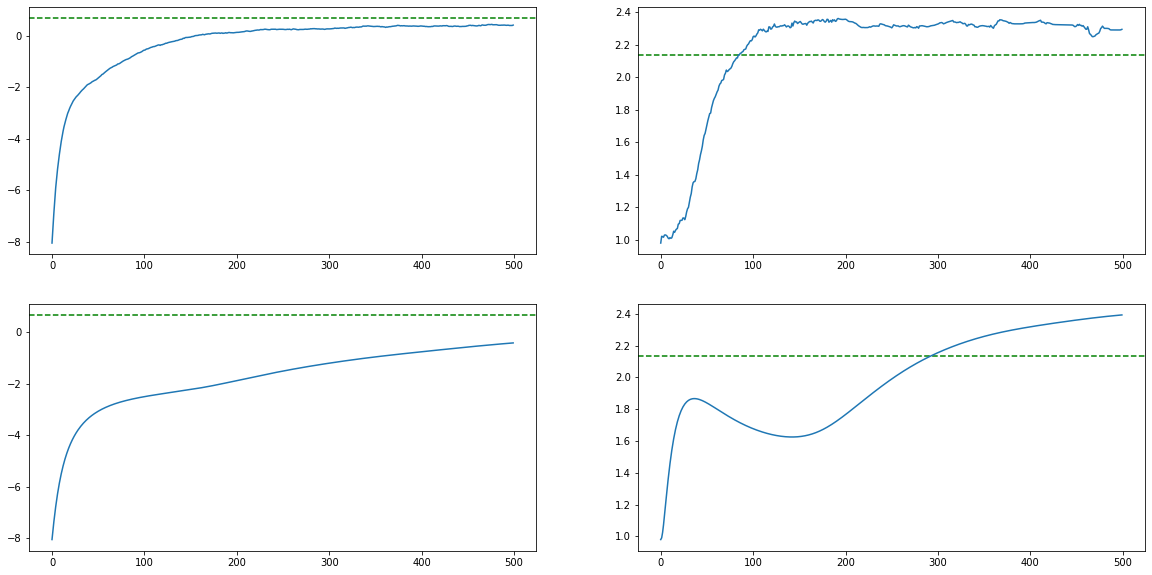

In [16]:
fig, axs = plt.subplots(2, 2, figsize=[20, 10])
neural_svgd_particles.plot_mean_and_std(target, axs=axs[0])
svgd_particles.plot_mean_and_std(target, axs=axs[1])

<AxesSubplot:>

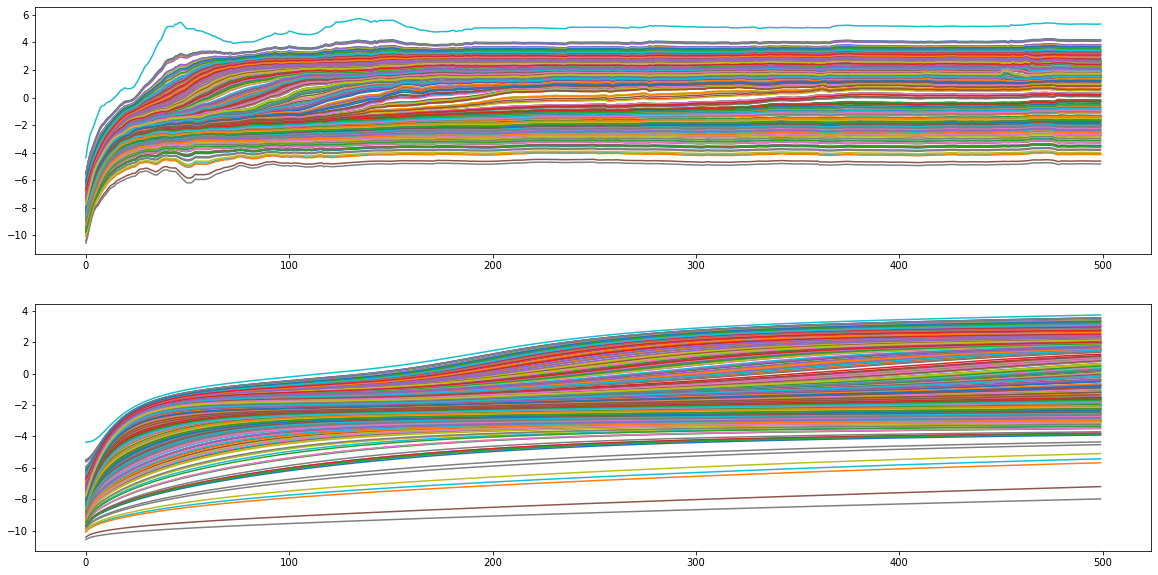

In [17]:
fig, axs = plt.subplots(2, figsize=[20, 10])
neural_svgd_particles.plot_trajectories(ax=axs[0])
svgd_particles.plot_trajectories(ax=axs[1])

Text(0.5, 1.0, 'SVGD')

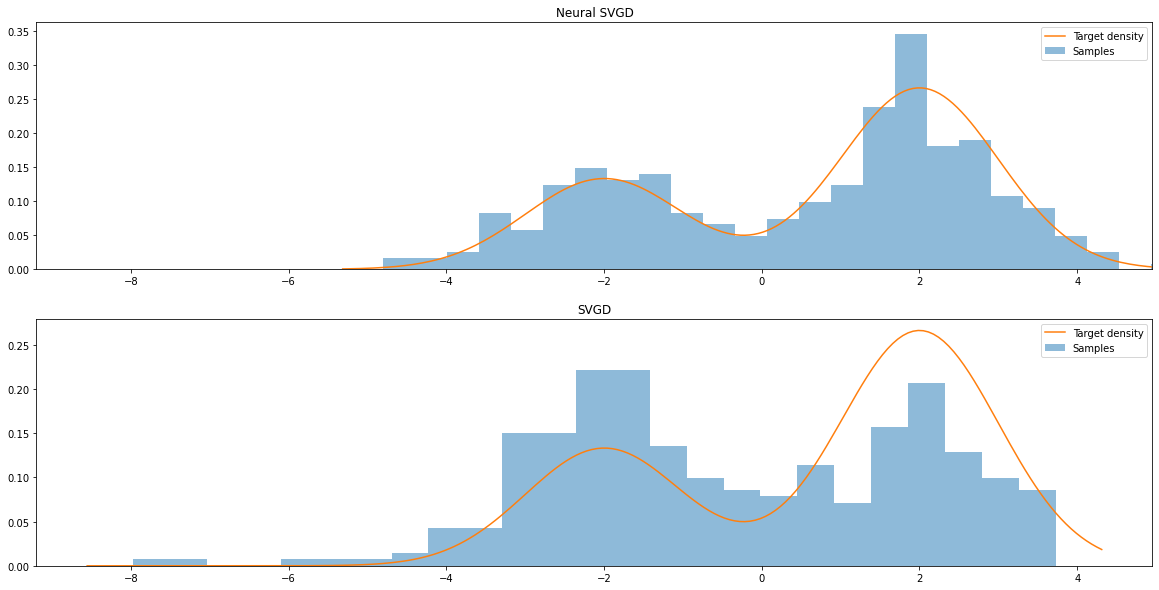

In [18]:
fig, axs = plt.subplots(2, figsize=[20, 10])
ax1 = neural_svgd_particles.plot_final(ax=axs[0], target=target)
ax1.set_title("Neural SVGD")

ax2 = svgd_particles.plot_final(ax=axs[1], target=target)
ax1.set_xlim(ax2.get_xlim())
ax2.set_title("SVGD")

In [19]:
# particles = score_particles
particles = svgd_particles

# learner = score_learner
# learner = svgd_learner
grad = kernel_gradient

samples = proposal.sample(1000)
v = kernel_gradient.get_field(samples)
# v = learner.get_field(samples)
# score = learner.get_score(samples)
# v_true = setup.grad_kl

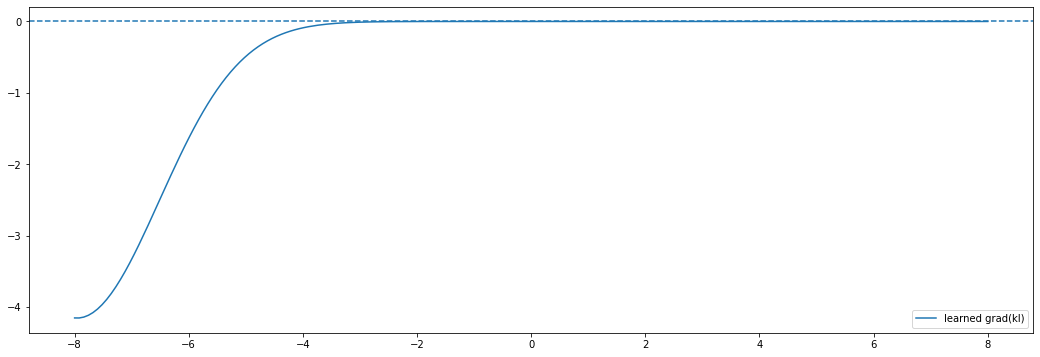

In [20]:
# @utils.reshape_input
# def dlogp(x):
#     return score(x) - v(x)

fig, ax = plt.subplots(figsize=[18, 6])
plot.plot_fun(utils.reshape_input(v),     lims=(-8, 8), label="learned grad(kl)")
# plot.plot_fun(utils.reshape_input(score), lims=(-8, 8), label="learned score")
plt.axhline(y=0, linestyle="--")
# plot.plot_fun(utils.negative(grad(target.logpdf)), lims=(-8, 8), label="-grad(logp)")
# ax.set_xlim(xlims)
ax.legend()